In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

In [2]:
### https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5
adata = sc.read_10x_h5(filename="../xenium_data/outs/cell_feature_matrix.h5")

In [3]:
adata

AnnData object with n_obs × n_vars = 167780 × 313
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
### https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz
df = pd.read_csv("../xenium_data/outs/cells.csv")

In [5]:
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()

In [6]:
adata

AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'

In [7]:
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [8]:
adata

AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [9]:
### Calculate quality control metrics
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

In [10]:
### calculate and print the percentage of control probes
cprobes = (adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100)
print(f"Negative DNA probe count % : {cprobes}")

Negative DNA probe count % : 0.08838749926953768


In [11]:
### calculate and print the percentage of control codewords 
cwords = (adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100)
print(f"Negative decoding count % : {cwords}")

Negative decoding count % : 0.006644247962710972


<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

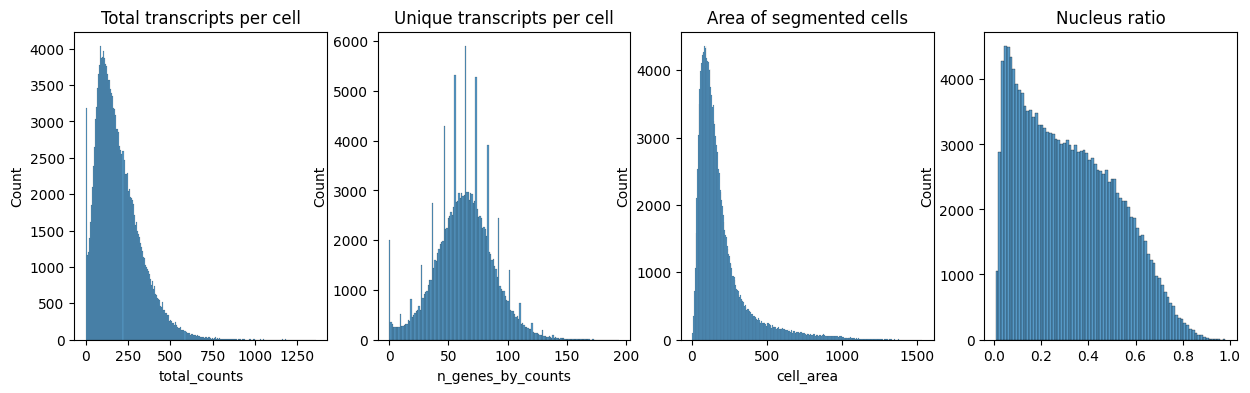

In [12]:
### plot the distribution of: 
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])

axs[1].set_title("Unique transcripts per cell")
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, ax=axs[1])

axs[2].set_title("Area of segmented cells")
sns.histplot(adata.obs["cell_area"], kde=False, ax=axs[2])

axs[3].set_title("Nucleus ratio")
sns.histplot(adata.obs["nucleus_area"] / adata.obs["cell_area"], kde=False, ax=axs[3])

In [13]:
## Filter the cells and genes
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

In [14]:
adata # 167780 × 313

AnnData object with n_obs × n_vars = 164000 × 313
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

In [15]:
## standard scanpy workflow
sc.pp.normalize_total(adata, inplace=True) # Normalize counts per cell
sc.pp.log1p(adata) # Logarithmize

# sc.pp.highly_variable_genes (adata) # 313 genes

sc.pp.pca(adata) # do principal component analysis
sc.pp.neighbors(adata) # compute a neighborhood graph
sc.tl.umap(adata) # embed the neighborhood graph of the data
sc.tl.leiden(adata, resolution=0.3) # cluster the cells into subgroups

/home/hamalibt/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/hamalibt/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


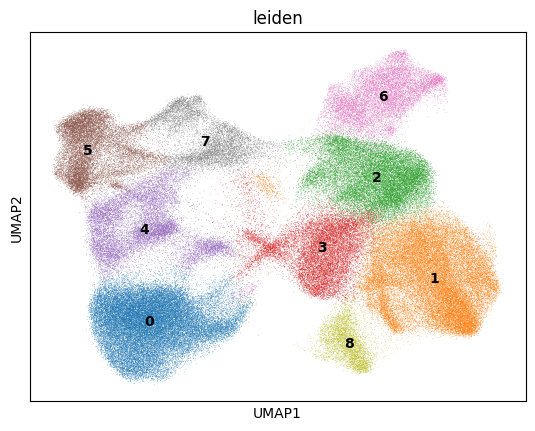

In [16]:
### Visualize cell clusters on UMAP
sc.pl.umap(adata, color="leiden", legend_loc='on data', wspace=0.4)

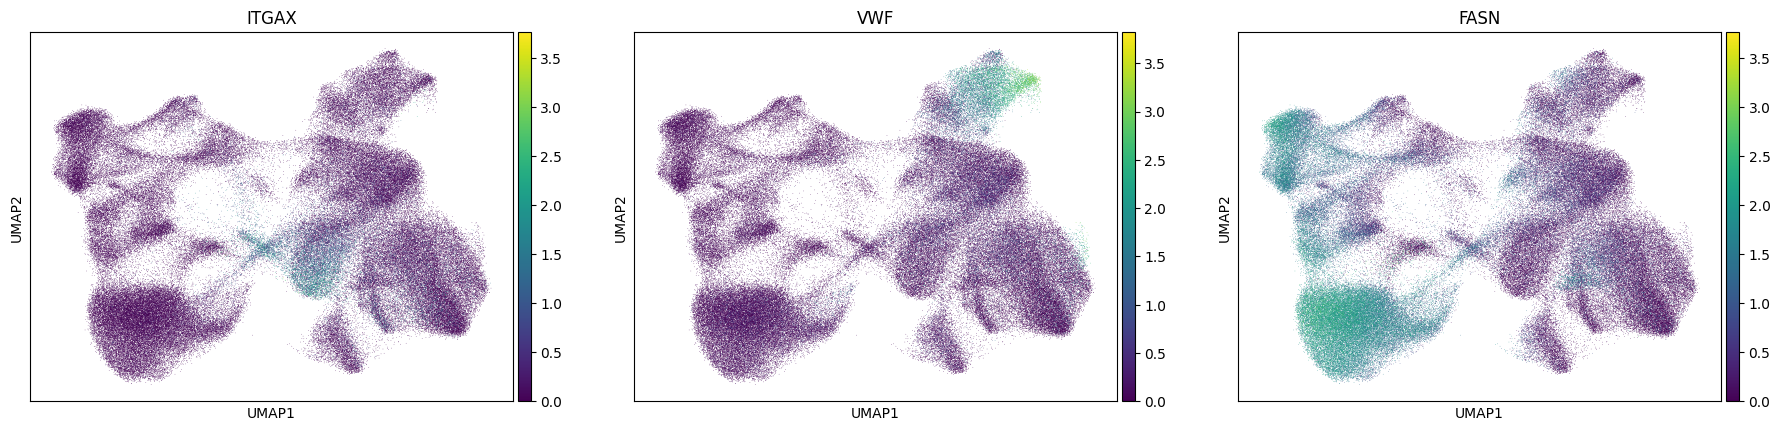

In [17]:
sc.pl.umap(adata, color=['ITGAX', 'VWF', 'FASN'], use_raw=False)

/home/hamalibt/.conda/envs/xenium_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


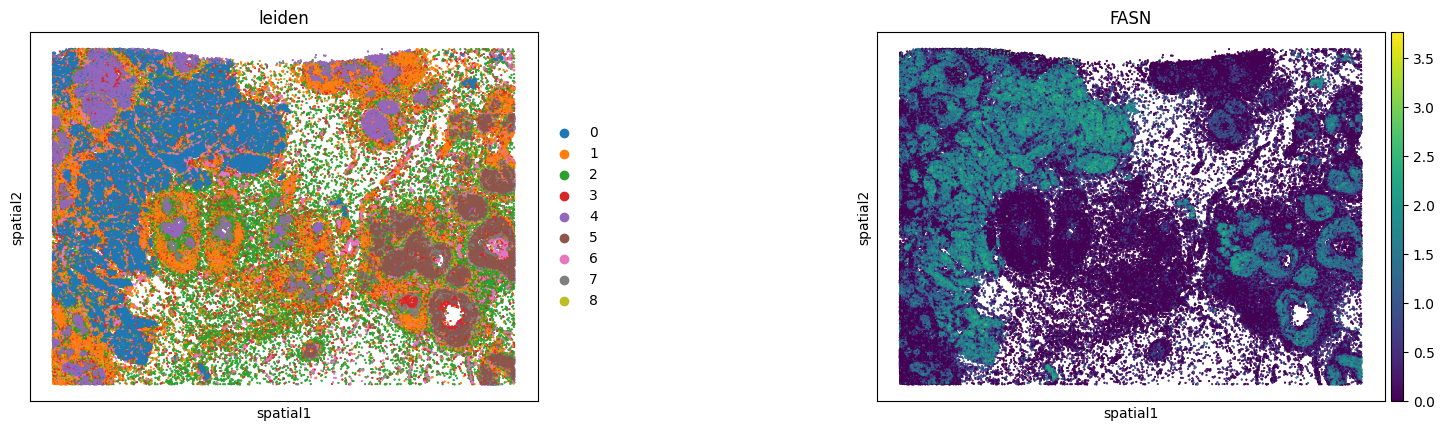

In [18]:
### Visualize cell clusters on spatial coordinates
sq.pl.spatial_scatter(adata, library_id="spatial", shape=None, color=["leiden", "FASN"], wspace=0.4)